```{image} ../images/zarr.png
:width: 400px
:align: center
```

# Formato Zarr para Datos Científicos

---

## 📚 Descripción general

En este cuadernillo aprenderás todo sobre **Zarr**, el formato ARCO más usado para datos científicos multidimensionales:

1. **¿Qué es Zarr?** - Conceptos fundamentales (Store, Group, Array)
2. **Exportar a Zarr** - Convertir datos radar a formato Zarr
3. **Carga perezosa** - Trabajar con archivos sin cargarlos en memoria
4. **Fragmentación** - Optimizar rendimiento según tu caso de uso
5. **Metadatos** - Inspeccionar estructura interna de archivos Zarr

Trabajarás con datos reales de radar meteorológico colombiano.

## ✅ Requisitos previos

| Concepto                                | Importancia | Notas                                   |
|-----------------------------------------|-------------|------------------------------------------|
| [Introducción a ARCO](./1.7.Introduccion-ARCO.ipynb) | Necesario | Conceptos ARCO y FAIR |
| [Introducción a Radar](./1.5.Introduccion-Radar.ipynb) | Necesario | Datos radar meteorológico |
| [Xarray](./1.4.Introduccion-Xarray.ipynb) | Necesario | Manipulación de datos multidimensionales |

⏱️ **Tiempo estimado de aprendizaje**:
- 📖 Solo lectura: 15–20 minutos
- 🏋️ Con actividades prácticas: 25–30 minutos

✍️ **Formato**: práctico, ejecuta y modifica el código

## Librerías

Importamos las librerías necesarias para este cuaderno.

In [ ]:
import xarray as xr  # Estructuras de datos multidimensionales
import xradar as xd  # Lectura y manipulación de datos radar
import zarr  # Formato de almacenamiento optimizado
import numpy as np  # Operaciones numéricas
import matplotlib.pyplot as plt  # Visualización
import cmweather  # Colormaps meteorológicos
import os  # Operaciones del sistema de archivos
from pathlib import Path  # Manejo de rutas

## 1. ¿Qué es Zarr?

---

**Zarr** es un **formato** para **almacenar** grandes arrays **N-dimensionales** — en **fragmentos (chunks)** — con **metadatos**, diseñado para acceso rápido y paralelo desde almacenamiento local o en la **nube**.

```{figure} ../images/whatiszarr.png
:width: 700px
:align: center
:name: fig-whatiszarr

Conceptos clave de Zarr: Store y Group. *Imagen cortesía: [Earthmover](https://earthmover.io/blog/what-is-zarr/)*
```

### Conceptos clave de Zarr:

**Store (Almacén)**:
- Un directorio en disco (e.g., `LocalStore`)
- Un bucket en la nube (e.g., `FsspecStore` para s3://…)
- En memoria (e.g., `MemoryStore`)

**Group (Grupo)**:
- Un grupo puede contener múltiples arrays Zarr relacionados
- Puede contener otros grupos (jerarquía anidada)
- Cada grupo tiene sus propios metadatos (en `zarr.json`)

### Ventajas de Zarr:

📦 **Compresión** - Para ahorrar espacio de almacenamiento  
🔀 **Acceso paralelo** - Por múltiples usuarios simultáneamente  
📡 **Transmisión eficiente** - Desde almacenamiento en nube  
⚡ **Procesamiento bajo demanda** - Sin necesidad de descargar todo

**Piensa en ello como tener una biblioteca donde puedes tomar solo los libros que necesitas, ¡en lugar de tener que llevarte toda la biblioteca!**

### Características clave de Zarr

1. **Formato abierto y libre** - No propietario, código abierto
2. **Compatible con NumPy** - Se integra perfectamente con el ecosistema científico de Python
3. **Compresión flexible** - Múltiples algoritmos de compresión disponibles
4. **Metadatos integrados** - Autodescriptivo, similar a NetCDF
5. **Almacenamiento jerárquico** - Soporta estructuras de grupos anidados
6. **Optimizado para nube** - Diseñado desde el inicio para object storage (S3, GCS, Azure)

### Zarr vs NetCDF: Comparación

| Característica | NetCDF | Zarr |
|----------------|--------|------|
| **Fragmentación** | Limitada | Flexible y optimizada |
| **Acceso paralelo** | Difícil | Nativo |
| **Almacenamiento nube** | Ineficiente | Optimizado |
| **Compresión** | Limitada | Múltiples opciones |
| **Escritura concurrente** | No | Sí |
| **Tamaño máximo** | Limitado por formato | Sin límite práctico |
| **Madurez** | Muy maduro | En crecimiento rápido |

---

## 2. Exportar Datos a Zarr

Ahora que entiendes qué es Zarr, ¡veámoslo en acción! Vamos a:

1. Cargar datos radar del cuadernillo anterior (1.5)
2. Exportarlos al formato Zarr
3. Examinar la estructura del archivo Zarr resultante

In [2]:
# Cargar datos radar usando xradar (del cuadernillo 1.5)
archivo_radar = "../data/CAR220809191504.RAWDSX2"

In [3]:
%%time
radar_dt = xd.io.open_iris_datatree(archivo_radar)

CPU times: user 1.13 s, sys: 1.13 s, total: 2.26 s
Wall time: 1.28 s


In [4]:
print("Datos radar cargados:")
radar_dt

Datos radar cargados:


<xarray.DataTree>
Group: /
│   Dimensions:              (sweep: 1)
│   Dimensions without coordinates: sweep
│   Data variables:
│       volume_number        int64 8B 0
│       platform_type        <U5 20B 'fixed'
│       instrument_type      <U5 20B 'radar'
│       time_coverage_start  <U20 80B '2022-08-09T19:15:05Z'
│       time_coverage_end    <U20 80B '2022-08-09T19:16:21Z'
│       longitude            float64 8B -71.33
│       altitude             float64 8B 206.0
│       latitude             float64 8B 4.564
│       sweep_fixed_angle    (sweep) float64 8B 0.5
│       sweep_group_name     (sweep) int64 8B 0
│   Attributes:
│       Conventions:      None
│       instrument_name:  carimagua-radar
│       version:          None
│       title:            None
│       institution:      None
│       references:       None
│       source:           Sigmet
│       history:          None
│       comment:          Primera tarea del modo precipitacion / 0.5
│       scan_name:        SURVP       
├── Group: /sweep_0
│       Dimensions:            (azimuth: 720, range: 994)
│       Coordinates:
│         * azimuth            (azimuth) float32 3kB 0.03571 0.5795 ... 359.0 359.6
│           elevation          (azimuth) float32 3kB ...
│           time               (azimuth) datetime64[ns] 6kB 2022-08-09T19:15:56.89100...
│         * range              (range) float32 4kB 1e+03 1.3e+03 ... 2.986e+05 2.989e+05
│           longitude          float64 8B ...
│           latitude           float64 8B ...
│           altitude           float64 8B ...
│       Data variables: (12/17)
│           DBTH               (azimuth, range) float32 3MB ...
│           DBZH               (azimuth, range) float32 3MB ...
│           VRADH              (azimuth, range) float32 3MB ...
│           WRADH              (azimuth, range) float32 3MB ...
│           ZDR                (azimuth, range) float32 3MB ...
│           KDP                (azimuth, range) float32 3MB ...
│           ...                 ...
│           DB_DBZE8           (azimuth, range) float32 3MB ...
│           sweep_mode         <U20 80B ...
│           sweep_number       int64 8B ...
│           prt_mode           <U7 28B ...
│           follow_mode        <U7 28B ...
│           sweep_fixed_angle  float64 8B ...
├── Group: /radar_parameters
│       Dimensions:    ()
│       Coordinates:
│           longitude  float64 8B ...
│           latitude   float64 8B ...
│           altitude   float64 8B ...
├── Group: /georeferencing_correction
│       Dimensions:    ()
│       Coordinates:
│           longitude  float64 8B ...
│           latitude   float64 8B ...
│           altitude   float64 8B ...
└── Group: /radar_calibration

In [5]:
# Exportar a Zarr
# Especificamos zarr_version=2 para compatibilidad amplia
zarr_path = "../data/radar_carimagua.zarr"

# Eliminar si existe para evitar errores
import shutil
if os.path.exists(zarr_path):
    shutil.rmtree(zarr_path)

# Exportar el DataTree completo
radar_dt.to_zarr(zarr_path, mode="w", zarr_version=2, consolidated=True)

print(f"✅ Datos exportados a: {zarr_path}")

✅ Datos exportados a: ../data/radar_carimagua.zarr


In [6]:
# Examinar estructura del archivo Zarr
# Zarr almacena datos en una estructura de directorio
print("Estructura del archivo Zarr:")
print("\nPrimeros 20 archivos/directorios:")
for i, (root, dirs, files) in enumerate(os.walk(zarr_path)):
    if i > 5:  # Limitar salida
        break
    level = root.replace(zarr_path, '').count(os.sep)
    indent = ' ' * 2 * level
    print(f"{indent}{os.path.basename(root)}/")
    subindent = ' ' * 2 * (level + 1)
    for file in files[:5]:  # Mostrar solo primeros 5 archivos por directorio
        print(f"{subindent}{file}")

Estructura del archivo Zarr:

Primeros 20 archivos/directorios:
radar_carimagua.zarr/
  .zattrs
  .zgroup
  .zmetadata
  altitude/
    .zarray
    .zattrs
    0
  georeferencing_correction/
    .zattrs
    .zgroup
    altitude/
      .zarray
      .zattrs
      0
    latitude/
      .zarray
      .zattrs
      0
    longitude/
      .zarray
      .zattrs
      0


---

## 3. Carga Perezosa (Lazy Loading)

Una de las ventajas más poderosas de Zarr es la **carga perezosa (lazy loading)**. Esto significa que podemos abrir un archivo Zarr gigante sin cargar todos los datos en memoria. Solo se cargan los datos cuando realmente los necesitamos.

In [7]:
%%time
radar_zarr = xr.open_datatree( # Abrir archivo Zarr
    zarr_path, 
    engine="zarr",
    chunks={},
    consolidated=True
)

CPU times: user 47.5 ms, sys: 12.6 ms, total: 60.1 ms
Wall time: 84.4 ms


In [8]:
# Esto NO carga los datos en memoria, solo los metadatos
print("Archivo Zarr abierto:")
radar_zarr

Archivo Zarr abierto:


<xarray.DataTree>
Group: /
│   Dimensions:              (sweep: 1)
│   Dimensions without coordinates: sweep
│   Data variables:
│       altitude             float64 8B ...
│       instrument_type      <U5 20B ...
│       latitude             float64 8B ...
│       longitude            float64 8B ...
│       platform_type        <U5 20B ...
│       sweep_fixed_angle    (sweep) float64 8B dask.array<chunksize=(1,), meta=np.ndarray>
│       sweep_group_name     (sweep) int64 8B dask.array<chunksize=(1,), meta=np.ndarray>
│       time_coverage_end    <U20 80B ...
│       time_coverage_start  <U20 80B ...
│       volume_number        int64 8B ...
│   Attributes:
│       Conventions:      None
│       instrument_name:  carimagua-radar
│       version:          None
│       title:            None
│       institution:      None
│       references:       None
│       source:           Sigmet
│       history:          None
│       comment:          Primera tarea del modo precipitacion / 0.5
│       scan_name:        SURVP       
├── Group: /georeferencing_correction
│       Dimensions:    ()
│       Coordinates:
│           altitude   float64 8B ...
│           latitude   float64 8B ...
│           longitude  float64 8B ...
├── Group: /radar_calibration
├── Group: /radar_parameters
│       Dimensions:    ()
│       Coordinates:
│           altitude   float64 8B ...
│           latitude   float64 8B ...
│           longitude  float64 8B ...
└── Group: /sweep_0
        Dimensions:            (azimuth: 720, range: 994)
        Coordinates:
            altitude           float64 8B ...
          * azimuth            (azimuth) float32 3kB 0.03571 0.5795 ... 359.0 359.6
            elevation          (azimuth) float32 3kB dask.array<chunksize=(720,), meta=np.ndarray>
            latitude           float64 8B ...
            longitude          float64 8B ...
          * range              (range) float32 4kB 1e+03 1.3e+03 ... 2.986e+05 2.989e+05
            time               (azimuth) datetime64[ns] 6kB dask.array<chunksize=(720,), meta=np.ndarray>
        Data variables: (12/17)
            DB_DBTE8           (azimuth, range) float32 3MB dask.array<chunksize=(180, 497), meta=np.ndarray>
            DB_DBZE8           (azimuth, range) float32 3MB dask.array<chunksize=(180, 497), meta=np.ndarray>
            DB_HCLASS          (azimuth, range) int16 1MB dask.array<chunksize=(360, 497), meta=np.ndarray>
            DBTH               (azimuth, range) float32 3MB dask.array<chunksize=(180, 497), meta=np.ndarray>
            DBZH               (azimuth, range) float32 3MB dask.array<chunksize=(180, 497), meta=np.ndarray>
            follow_mode        <U7 28B ...
            ...                 ...
            sweep_fixed_angle  float64 8B ...
            sweep_mode         <U20 80B ...
            sweep_number       int64 8B ...
            VRADH              (azimuth, range) float32 3MB dask.array<chunksize=(180, 497), meta=np.ndarray>
            WRADH              (azimuth, range) float32 3MB dask.array<chunksize=(180, 497), meta=np.ndarray>
            ZDR                (azimuth, range) float32 3MB dask.array<chunksize=(180, 497), meta=np.ndarray>

In [9]:
# Cargar solo un subconjunto de datos
subset = radar_zarr["sweep_0"]
subset 

<xarray.DataTree 'sweep_0'>
Group: /sweep_0
    Dimensions:            (sweep: 1, azimuth: 720, range: 994)
    Coordinates:
        altitude           float64 8B ...
      * azimuth            (azimuth) float32 3kB 0.03571 0.5795 ... 359.0 359.6
        elevation          (azimuth) float32 3kB dask.array<chunksize=(720,), meta=np.ndarray>
        latitude           float64 8B ...
        longitude          float64 8B ...
      * range              (range) float32 4kB 1e+03 1.3e+03 ... 2.986e+05 2.989e+05
        time               (azimuth) datetime64[ns] 6kB dask.array<chunksize=(720,), meta=np.ndarray>
    Dimensions without coordinates: sweep
    Data variables: (12/17)
        DB_DBTE8           (azimuth, range) float32 3MB dask.array<chunksize=(180, 497), meta=np.ndarray>
        DB_DBZE8           (azimuth, range) float32 3MB dask.array<chunksize=(180, 497), meta=np.ndarray>
        DB_HCLASS          (azimuth, range) int16 1MB dask.array<chunksize=(360, 497), meta=np.ndarray>
        DBTH               (azimuth, range) float32 3MB dask.array<chunksize=(180, 497), meta=np.ndarray>
        DBZH               (azimuth, range) float32 3MB dask.array<chunksize=(180, 497), meta=np.ndarray>
        follow_mode        <U7 28B ...
        ...                 ...
        sweep_fixed_angle  float64 8B ...
        sweep_mode         <U20 80B ...
        sweep_number       int64 8B ...
        VRADH              (azimuth, range) float32 3MB dask.array<chunksize=(180, 497), meta=np.ndarray>
        WRADH              (azimuth, range) float32 3MB dask.array<chunksize=(180, 497), meta=np.ndarray>
        ZDR                (azimuth, range) float32 3MB dask.array<chunksize=(180, 497), meta=np.ndarray>

In [10]:
# Acceder a una variable específica
# Los datos aún no se cargan en memoria - están "lazy"
dbzh = radar_zarr["sweep_0"]["DBZH"]

print("Variable DBZH (lazy):")
dbzh

Variable DBZH (lazy):


<xarray.DataArray 'DBZH' (azimuth: 720, range: 994)> Size: 3MB
dask.array<open_dataset-DBZH, shape=(720, 994), dtype=float32, chunksize=(180, 497), chunktype=numpy.ndarray>
Coordinates:
    altitude   float64 8B ...
  * azimuth    (azimuth) float32 3kB 0.03571 0.5795 1.019 ... 358.6 359.0 359.6
    elevation  (azimuth) float32 3kB dask.array<chunksize=(720,), meta=np.ndarray>
    latitude   float64 8B ...
    longitude  float64 8B ...
  * range      (range) float32 4kB 1e+03 1.3e+03 1.6e+03 ... 2.986e+05 2.989e+05
    time       (azimuth) datetime64[ns] 6kB dask.array<chunksize=(720,), meta=np.ndarray>
Attributes:
    long_name:      Equivalent reflectivity factor H
    standard_name:  radar_equivalent_reflectivity_factor_h
    units:          dBZ

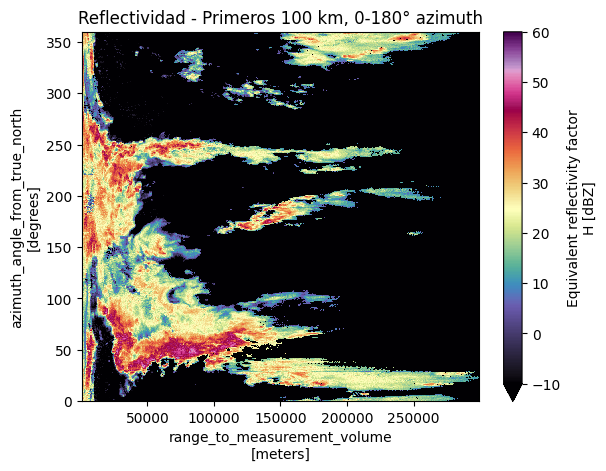

In [11]:
# Visualizar el subconjunto
dbzh.plot(cmap="ChaseSpectral", vmin=-10, vmax=60)
plt.title("Reflectividad - Primeros 100 km, 0-180° azimuth")
plt.show()

````{admonition} Punto de control
:class: success

En este punto deberías poder:
- ✅ Entender los conceptos Store, Group y Array de Zarr
- ✅ Exportar datos xarray/xradar a formato Zarr
- ✅ Abrir archivos Zarr con carga perezosa (lazy loading)
- ✅ Acceder a subconjuntos de datos sin cargar todo el archivo
- ✅ Entender la estructura de directorios de Zarr

Si tienes dudas, repasa las secciones anteriores.
````

---

## 4. Actividades Prácticas

Ahora es tu turno de experimentar con Zarr. Estas actividades te ayudarán a dominar fragmentación, rendimiento y metadatos.

---

### 🏋️ Práctica 1: Exportar con fragmentación personalizada

Zarr permite especificar cómo se fragmentan (chunk) los datos. Una fragmentación óptima puede mejorar significativamente el rendimiento.

**Contexto sobre fragmentación:**

La fragmentación determina qué tamaño tienen los "bloques" de datos. Opciones comunes:

📏 **Estrategias de fragmentación:**
- `{azimuth: 180, range: 250}` → Fragmentos de tamaño específico (bueno para acceso parcial)
- `{azimuth: -1, range: -1}` → Un solo fragmento por dimensión (bueno para cargar dimensiones completas)
  - **¿Qué significa `-1`?** → Toda la dimensión en un solo chunk (sin fragmentación adicional)
- `{azimuth: 360, range: 497}` → Fragmentos medianos (balance entre los dos anteriores)

**Tareas:**
1. Carga el dataset de radar nuevamente
2. Accede al sweep_0 como Dataset
3. Aplica fragmentación personalizada usando `.chunk()` con `{azimuth: 180, range: 250}`
4. Exporta a Zarr con el nombre `radar_chunked.zarr`
5. Compara el tamaño con la versión anterior
6. **Reflexión:** ¿En qué caso de uso sería mejor cada estrategia de fragmentación?

In [12]:
# Tu código aquí

````{admonition} Solución
:class: dropdown

```python
# 1. Cargar datos
radar_dt = xd.io.open_iris_datatree("../data/CAR220809191504.RAWDSX2")

# 2. Acceder a sweep_0
sweep0 = radar_dt["sweep_0"].ds

# 3. Aplicar fragmentación personalizada
sweep0_chunked = sweep0.chunk({"azimuth": -1, "range": -1})

# 4. Exportar
zarr_chunked_path = "../data/radar_chunked.zarr"
if os.path.exists(zarr_chunked_path):
    shutil.rmtree(zarr_chunked_path)
    
sweep0_chunked.to_zarr(zarr_chunked_path, mode="w")

# 5. Ver el nuevo esquema de partición o chunking 
sweep0_back = xr.open_zarr(zarr_chunked_path, chunks={})
sweep0_back["DBZH"]
```
````

---

### 🏋️ Práctica 2: Comparar velocidad de acceso

Compara la velocidad de lectura entre el formato original y Zarr.

**Tareas:**
1. Usa `%%time` para medir el tiempo de carga del archivo original
2. Usa `%%time` para medir el tiempo de apertura del archivo Zarr (lazy)
3. Mide el tiempo de cargar un subconjunto desde Zarr
4. Explica las diferencias de rendimiento

In [13]:
# Tu código aquí

````{admonition} Solución
:class: dropdown

```python
# 1. Tiempo de carga del formato original
print("=== Formato original RAWDSX2 ===")
%time radar_orig = xd.io.open_iris_datatree("../data/CAR220809191504.RAWDSX2")

# 2. Tiempo de apertura Zarr (lazy)
print("\n=== Zarr (lazy loading) ===")
%time radar_z = xr.open_datatree(zarr_path,engine="zarr")

# 3. Tiempo de cargar subconjunto desde Zarr
print("\n=== Cargar subconjunto desde Zarr ===")
%time subset = radar_z = xr.open_datatree(zarr_path, engine="zarr", group="sweep_0")

print("\n📊 Interpretación:")
print("- RAWDSX2: Carga completa necesaria")
print("- Zarr lazy: Apertura casi instantánea (solo metadatos)")
print("- Zarr subset: Solo carga los fragmentos necesarios")
print("\n✅ Ventaja: Zarr permite exploración rápida y acceso selectivo")
```
````

---

### 🏋️ Práctica 3: Inspeccionar metadatos Zarr

**Contexto:**

Zarr almacena metadatos en archivos JSON legibles por humanos. Esto te permite:
- ✅ Verificar la compresión aplicada sin cargar datos
- ✅ Confirmar el tamaño de fragmentos (chunks)
- ✅ Entender el esquema de datos antes de procesarlos
- ✅ Diagnosticar problemas de rendimiento

Los archivos clave son:
- `.zattrs`: Atributos del grupo (metadatos personalizados)
- `.zarray`: Metadata del array (forma, tipo, compresión, chunks)
- `.zgroup`: Indica que es un grupo Zarr

Exploraremos estos archivos para entender cómo Zarr organiza la información.

**Tareas:**
1. Lee el archivo `.zattrs` del grupo raíz de tu archivo Zarr
2. Lee el archivo `.zarray` de la variable DBZH
3. Identifica en el `.zarray`: tipo de compresión, forma del array, fragmentación, tipo de datos
4. Explica qué significa cada campo y cómo afecta el rendimiento

In [14]:
# Tu código aquí

````{admonition} Solución
:class: dropdown

```python
import json

# 1. Leer atributos del grupo raíz
print("=== Atributos del grupo raíz (.zattrs) ===")
with open(f"{zarr_path}/sweep_0/.zattrs", 'r') as f:
    root_attrs = json.load(f)
    print(json.dumps(root_attrs, indent=2)[:500])  # Primeros 500 caracteres

# 2. Leer metadata del array DBZH
print("\n=== Metadata del array DBZH (.zarray) ===")
with open(f"{zarr_path}/sweep_0/DBZH/.zarray", 'r') as f:
    dbzh_meta = json.load(f)
    print(json.dumps(dbzh_meta, indent=2))

# 3 y 4. Identificar y explicar campos
print("\n📋 Explicación de campos clave:")
print(f"- shape: {dbzh_meta['shape']} → Forma del array (azimuth, range)")
print(f"- chunks: {dbzh_meta['chunks']} → Tamaño de cada fragmento")
print(f"- dtype: {dbzh_meta['dtype']} → Tipo de datos (float32)")
print(f"- compressor: {dbzh_meta['compressor']['id']} → Algoritmo de compresión")
print(f"- order: {dbzh_meta['order']} → Orden de memoria (C=row-major)")
print(f"- fill_value: {dbzh_meta['fill_value']} → Valor para datos faltantes")
```
````

---

## Resumen

En este cuadernillo dominaste el formato Zarr:

✅ **Conceptos fundamentales**: Store, Group, Array, fragmentación

✅ **Exportación**: Convertiste datos radar a formato Zarr cloud-optimized

✅ **Carga perezosa**: Abriste archivos grandes sin cargar todo en memoria

✅ **Fragmentación**: Optimizaste estrategias de chunking

✅ **Metadatos**: Inspeccionaste estructura interna JSON

✅ **Rendimiento**: Comparaste velocidad con formatos tradicionales

Ahora puedes trabajar eficientemente con grandes volúmenes de datos científicos usando formatos ARCO.

### 💡 ¿Cuándo usar Zarr vs NetCDF?

**Usa Zarr cuando:**
- 📈 Datasets muy grandes (> 1 GB)
- ☁️ Almacenamiento en nube (S3, GCS, Azure)
- 🔀 Acceso paralelo por múltiples usuarios
- ⚡ Acceso rápido a subconjuntos
- 📊 Pipelines de análisis escalables

**Usa NetCDF cuando:**
- 💾 Sistemas de archivos locales
- 📁 Datasets pequeños (< 1 GB)
- 🔒 Compatibilidad con software legacy
- 📜 Estándares CF requeridos

### ¿Qué sigue?

Ahora que dominas los formatos de datos científicos (NetCDF, GRIB, Zarr), estás listo para aplicar estos conocimientos en el acceso y análisis de datos hidrometeorológicos reales.

### Temas avanzados para explorar:

- **Kerchunk**: Virtualización de NetCDF como Zarr sin conversión
- **Dask**: Procesamiento paralelo y distribuido
- **Intake**: Catálogos de datos ARCO
- **Pangeo**: Ecosistema de análisis científico en la nube

### Recursos recomendados:

- 📖 [Documentación oficial de Zarr](https://zarr.readthedocs.io/)
- 🌐 [Project Pythia Radar Cookbook](https://projectpythia.org/radar-cookbook/)
- 🔬 [Xarray documentation](https://docs.xarray.dev/)
- 📡 [Xradar documentation](https://docs.openradarscience.org/projects/xradar/)
- ☁️ [Pangeo ecosystem](https://pangeo.io/)

👉 Continúa con: **Sección 2 - Acceso a datos hidrometeorológicos**

---

## 📚 Referencias

- Miles, A. et al. (2022). Zarr: A format for the storage of chunked, compressed, N-dimensional arrays. https://zarr.dev
- Abernathey, R. et al. (2021). Cloud-Native Repositories for Big Scientific Data. *Computing in Science & Engineering*, 23(2), 26-35.
- WMO (2021). Manual on the WMO Integrated Global Observing System (WIGOS). WMO-No. 1160.
- Helmus, J. J., & Collis, S. M. (2016). The Python ARM Radar Toolkit (Py-ART). *Journal of Open Research Software*, 4(1).